In [1]:
import numpy as np , math , time , os
from skimage import io , filters
from CarDetection_HOG_adding_features import display, readimg, get_hist_grid , Block_Normalization, Block_Normalization_Preprocess
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from skimage.transform import resize
n_imgs = 16000
n_win_width = 64
n_cell_pxls = 8
n_block_cells = 1
n_angles = 18
n_win_width_hists =(n_win_width-n_cell_pxls*n_block_cells)//n_cell_pxls+1 
n_hist_vals = n_win_width_hists * n_win_width_hists*n_angles*n_block_cells*n_block_cells
test_ratio = 0.2
thres = 1
img_scales = [1 , 0.8 , 0.6]

from skimage import feature
#import imutils
import cv2

In [2]:
#hog parameters
winSize = (n_win_width,n_win_width)
blockSize = (n_block_cells*n_cell_pxls,n_block_cells*n_cell_pxls)
blockStride = (n_cell_pxls,n_cell_pxls)
cellSize = (n_cell_pxls,n_cell_pxls)
nbins = n_angles
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

In [3]:
def get_hog(img):
    hog_res = np.empty(0)
    for i in range(3):
        #hog_res = np.append(hog_res, feature.hog(img[:,:,i], orientations=n_angles, pixels_per_cell=(n_cell_pxls, n_cell_pxls),cells_per_block=(n_block_cells, n_block_cells), transform_sqrt=True, block_norm="L1"))
        hog_res = np.append(hog_res, hog.compute(img[:,:,i]))
    return hog_res

In [4]:
t = time.time()

x = np.zeros((n_imgs,n_hist_vals*3) , dtype=np.float)
y = np.zeros((n_imgs) , dtype=np.float)

vehicles_data_path = os.getcwd() + '\\Vehicles\\'
non_vehicles_data_path = os.getcwd() + '\\Non-Vehicles\\'

img_index = 1
#Reading Vehicles & Non-Vehicles images:
for i in range(0 , n_imgs//2 , 2):
    #img = io.imread(vehicles_data_path + "v_ (" + str(img_index) + ").png")
    img = readimg(vehicles_data_path + "v_ (" + str(img_index) + ").png")
    #img = resize(img, (n_win_width, n_win_width), anti_aliasing=True)
    #x[i,:] = Block_Normalization(get_hist_grid(img , n_cell_pxls))
    '''get_hist_grid(img)
    Block_Normalization_Preprocess()
    x[i,:] = Block_Normalization(0,0)'''
    x[i,:] = get_hog(img)
    y[i] = 1.0
    
    #img = io.imread(non_vehicles_data_path + "nv_ (" + str(img_index) + ").png")
    img = readimg(non_vehicles_data_path + "nv_ (" + str(img_index) + ").png")
    #img = resize(img, (n_win_width, n_win_width), anti_aliasing=True)
    #x[i+1,:] = Block_Normalization(get_hist_grid(img , n_cell_pxls))
    '''get_hist_grid(img)
    Block_Normalization_Preprocess()
    x[i+1,:] = Block_Normalization(0,0)'''
    x[i+1,:] = get_hog(img)
    y[i+1] = 0.0
    
    img_index += 1
    
print("Train and test images reading and features extraction time: " , time.time()-t)

Train and test images reading and features extraction time:  8.1627779006958


In [5]:
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = test_ratio)
clf = SVC(kernel='linear')
t0 = time.time()
clf.fit(x_train , y_train)
t1 = time.time()
print("Training Time: " , t1-t0)

t2 = time.time()
p = clf.predict(x_test)
t3 = time.time()
print("Prediction Time: " , t3-t2)
print('Prediction ', p)
print('Accuracy ' , accuracy_score(y_test , p))

Training Time:  33.2335319519043
Prediction Time:  7.837517738342285
Prediction  [0. 0. 1. ... 0. 0. 0.]
Accuracy  0.99875


In [6]:
def Classify(img):
    res = clf.predict(img)
    return res[0]

In [7]:
def Crop_Image(img, deno):
    return img[img.shape[0]//deno : img.shape[0]]

In [8]:
def Slide_Window(img , window_size , step, r, c, ratio):
    h = img.shape[0] - window_size + 1
    w = img.shape[1] - window_size + 1
    
    R,C = img.shape[0] , img.shape[1]
    mat = np.zeros((r,c) , dtype = np.int)
    window = np.zeros((1, n_hist_vals*3) , dtype=np.float)
    #i = -1
    #get_hist_grid(img)
    #Block_Normalization_Preprocess()
    
    for I in range(0 , R , step):
        if(R-I >= window_size):
            #i += 1
            #j = 0
            for J in range(0 , C , step):
                if(C-J >= window_size):
                    #window[0,:] = Block_Normalization(get_hist_grid(img[I : I+window_size , J : J+window_size] , n_cell_pxls))
                    #window[0,:] = Block_Normalization(I, J)
                    window[0,:] = get_hog(img[I : I+window_size , J : J+window_size])
                    mat[int(round(I*ratio))][int(round(J*ratio))] = Classify(window)
                    
                    #j += 1
        
                else:
                    break
        else:
            break
                              
    return mat

In [9]:
def get_heatmap(img, win_width, step):
    #img = Crop_Image(img,3)
    r, c = img.shape[0], img.shape[1]
    img_scales_len = len(img_scales)
    fin_pxl_mat = np.zeros((r, c), dtype=int)
    for k in range(img_scales_len):
        r_new, c_new = int(round(r*img_scales[k])), int(round(c*img_scales[k]))
        print('Calculating heatmap of scale: '+str(r_new)+', '+str(c_new))
        resz_img = cv2.resize(im, (c_new, r_new))
        ratio = 1.0/img_scales[k]
        win_mat=Slide_Window(resz_img, win_width, step, r, c, ratio)
        for i in range(r-win_width+1):
            for j in range(1, c-win_width+1):
                win_mat[i,j]+=win_mat[i,j-1]
        for j in range(c-win_width+1):
            for i in range(1, r-win_width+1):
                win_mat[i,j]+=win_mat[i-1,j]
        pxl_mat = np.zeros((r, c), dtype=int)
        resz_win_width = int(round(win_width*ratio))
        for i in range(r):
            for j in range(c):
                tl_i, tl_j = max(i-resz_win_width+1, 0), max(j-resz_win_width+1, 0)
                br_i, br_j = min(i+resz_win_width-1, r-1), min(j+resz_win_width-1, c-1)
                br_i, br_j = br_i-resz_win_width+1, br_j-resz_win_width+1
                sum = win_mat[br_i, br_j]
                if(tl_i-1>=0):
                    sum -= win_mat[tl_i-1, br_j]
                if(tl_j-1>=0):
                    sum -= win_mat[br_i, tl_j-1]
                if(tl_i-1>=0 and tl_j-1>=0):
                    sum += win_mat[tl_i-1, tl_j-1]
                if(sum < thres):
                    sum = 0
                pxl_mat[i, j] = sum
        fin_pxl_mat += pxl_mat
    return fin_pxl_mat

In [23]:
t4 = time.time()
im = readimg('x3.png')
im = Crop_Image(im, 4)
im = cv2.resize(im, (614, 308))
print(im.shape)
qt = get_heatmap(im , n_win_width, n_cell_pxls)
t5 = time.time()
print("Image reading and Heatmap generation Time: ", t5-t4)
#print(qt)

(308, 614, 3)
Calculating heatmap of scale: 308, 614
Calculating heatmap of scale: 246, 491
Calculating heatmap of scale: 185, 368
Image reading and Heatmap generation Time:  12.60123610496521


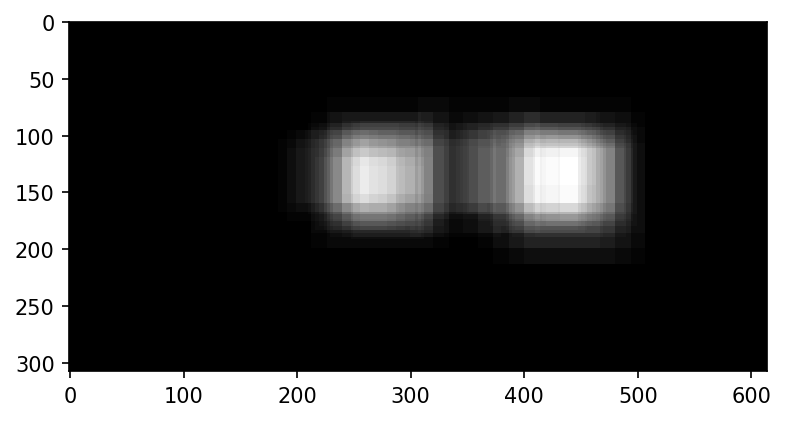

In [24]:
display(qt, True)

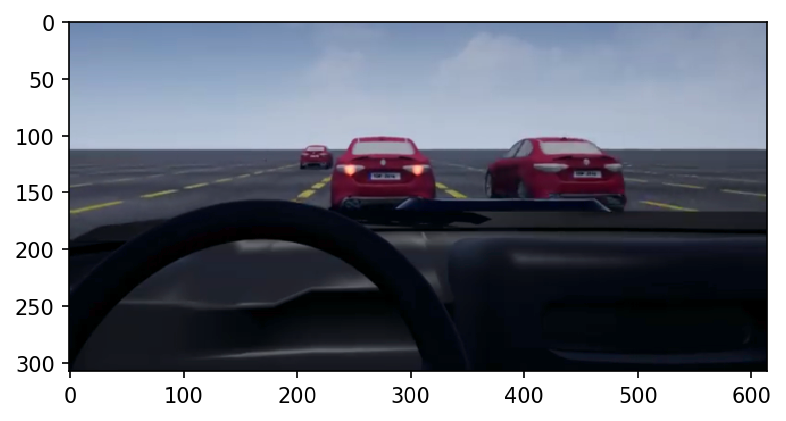

In [25]:
display(cv2.cvtColor(im, cv2.COLOR_LUV2RGB), False)